In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import logging
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer.autoguide.guides import AutoGuideList,AutoGuide
from pyro.infer import SMCFilter

from pyro.infer import MCMC, NUTS

In [2]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 200

assert pyro.__version__.startswith('1.8.6')

In [3]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [ ]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(60):
    data.append(torch.tensor(1.0))
for _ in range(40):
    data.append(torch.tensor(0.0))

In [45]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the ernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    

In [11]:
def guide_0(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    sample = pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))
    return sample
    
def guide_1(data):

    smc.init(initial=torch.tensor([1.0, 0.0]))
    for y in ys[1:]:
        smc.step(y)

In [9]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

In [47]:
guide = AutoGuideList(model)
guide.append(guide_0)
guide.append(guide_1)

auto_guide = pyro.infer.autoguide.AutoGuide(model)

smc = SMCFilter(model, auto_guide, num_particles=100, max_plate_nesting=0)
smc?
svi = SVI(model, guide_0, optimizer, loss=Trace_ELBO())

In [43]:
losses= [] 
p = 0.5
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 100 == 0:
        print(step)
        logging.info("Elbo loss: {}".format(loss))


0
100


In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

In [5]:
def generate_data(process_noise = 1.0, measurement_noise=1.0, timesteps=500):
    model = SimpleHarmonicModel(process_noise, measurement_noise)

    state = {}
    initial = torch.tensor([1.0, 0.0])
    model.init(state, initial=initial)
    zs = [initial]
    ys = [None]
    for t in range(timesteps):
        z, y = model.step(state)
        zs.append(z)
        ys.append(y)

    return zs, ys

In [12]:
class SimpleHarmonicModel:
    def __init__(self, process_noise, measurement_noise):
        self.A = torch.tensor([[0.0, 1.0], [-1.0, 0.0]])
        self.B = torch.tensor([3.0, 3.0])
        self.sigma_z = torch.tensor(process_noise)
        self.sigma_y = torch.tensor(measurement_noise)

    def init(self, state, initial):
        self.t = 0
        state["z"] = pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1
        state["z"] = pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(state["z"].matmul(self.A), self.B * self.sigma_z).to_event(1),
        )
        y = pyro.sample(
            "y_{}".format(self.t), dist.Normal(state["z"][..., 0], self.sigma_y), obs=y
        )
        return state["z"], y


class SimpleHarmonicModel_Guide:
    def __init__(self, model):
        self.model = model

    def init(self, state, initial):
        self.t = 0
        pyro.sample("z_init", dist.Delta(initial, event_dim=1))

    def step(self, state, y=None):
        self.t += 1

        # Proposal distribution
        pyro.sample(
            "z_{}".format(self.t),
            dist.Normal(
                state["z"].matmul(self.model.A), torch.tensor([1.0, 1.0])
            ).to_event(1),
        )

model = SimpleHarmonicModel(1.0,1.0)
guide = SimpleHarmonicModel_Guide(model)

smc = SMCFilter(model, guide, num_particles=100, max_plate_nesting=0)

logging.info("Generating data")
zs, ys = generate_data(1.0,1.0)

logging.info("Filtering")

smc.init(initial=torch.tensor([1.0, 0.0]))
for y in ys[1:]:
    smc.step(y)

logging.info("At final time step:")
z = smc.get_empirical()["z"]
logging.info("truth: {}".format(zs[-1]))
logging.info("mean: {}".format(z.mean))
logging.info("std: {}".format(z.variance**0.5))


zs[-1],z.mean,z.variance

(tensor([-95.2456,  32.5132]),
 tensor([-94.4802,  28.8068]),
 tensor([0.5008, 0.7462]))

In [13]:
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [15]:
losses= [] 
p = 0.5
# do gradient steps
for step in range(n_steps):
    loss = svi.step(zs)
    losses.append(loss)
    if step % 100 == 0:
        print(step)
        logging.info("Elbo loss: {}".format(loss))

ValueError: <__main__.SimpleHarmonicModel_Guide object at 0x000001C493BB8D50> is not callable, did you mean to pass it as a keyword arg?

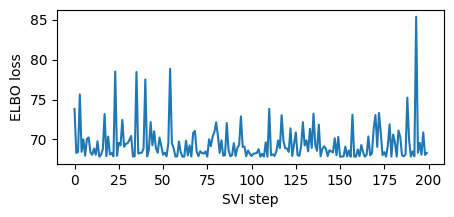

In [66]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");